In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
from scipy.spatial import Voronoi, voronoi_plot_2d

In [2]:
weekOneTracking = pd.read_csv("tracking_week_1.csv")

In [3]:
weekOneTracking

,gameId,playId,nflId,displayName,frameId,frameType,time,jerseyNumber,club,playDirection,x,y,s,a,dis,o,dir,event
0,2022091200,64,35459.0,Kareem Jackson,1,BEFORE_SNAP,2022-09-13 00:16:03.5,22.0,DEN,right,51.06,28.55,0.72,0.37,0.07,246.17,68.34,huddle_break_offense
1,2022091200,64,35459.0,Kareem Jackson,2,BEFORE_SNAP,2022-09-13 00:16:03.6,22.0,DEN,right,51.13,28.57,0.71,0.36,0.07,245.41,71.21,NaN
2,2022091200,64,35459.0,Kareem Jackson,3,BEFORE_SNAP,2022-09-13 00:16:03.7,22.0,DEN,right,51.20,28.59,0.69,0.23,0.07,244.45,69.90,NaN
3,2022091200,64,35459.0,Kareem Jackson,4,BEFORE_SNAP,2022-09-13 00:16:03.8,22.0,DEN,right,51.26,28.62,0.67,0.22,0.07,244.45,67.98,NaN
4,2022091200,64,35459.0,Kareem Jackson,5,BEFORE_SNAP,2022-09-13 00:16:03.9,22.0,DEN,right,51.32,28.65,0.65,0.34,0.07,245.74,62.83,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7104695,2022090800,3696,NaN,football,171,AFTER_SNAP,2022-09-09 03:07:37.7,NaN,football,left,1.70,0.62,14.42,5.36,1.47,NaN,NaN,pass_outcome_incomplete
7104696,2022090800,3696,NaN,football,172,AFTER_SNAP,2022-09-09 03:07:37.8,NaN,football,left,0.59,0.01,3.60,0.06,1.27,NaN,NaN,NaN
7104697,2022090800,3696,NaN,football,173,AFTER_SNAP,2022-09-09 03:07:37.9,NaN,football,left,0.23,-0.07,3.60,0.23,0.38,NaN,NaN,NaN
7104698,2022090800,3696,NaN,football,174,AFTER_SNAP,2022-09-09 03:07:38,NaN,football,left,-0.13,-0.17,3.63,0.06,0.37,NaN,NaN,NaN


In [4]:
players = pd.read_csv("players.csv")

In [466]:
plays = pd.read_csv("plays.csv")

In [5]:
weekOneTracking = pd.merge(
    weekOneTracking,
    players[['nflId','position']],
    how = "left",
    left_on=['nflId'],
    right_on=['nflId']
)

In [570]:
samplePlay = weekOneTracking[(weekOneTracking['gameId']==2022091101)&(weekOneTracking['playId']==184)&(weekOneTracking['displayName']!="football")&(weekOneTracking['frameId']==161)]

In [459]:
from shapely.geometry import Polygon, Point
from shapely.ops import unary_union

In [571]:
def voronoi_visual(samplePlay):
    samplePlay = pd.merge(
        samplePlay,
        plays[['gameId','playId','yardlineNumber','absoluteYardlineNumber']],
        how = 'left',
        left_on = ['gameId','playId'],
        right_on = ['gameId','playId']
    )
    samplePlayPoints = samplePlay[['nflId','x','y','club','position', 'yardlineNumber','absoluteYardlineNumber', 'frameId', 'playId']]
    new_rows = []

    # Loop over each row in samplePlayPoints
    for _, row in samplePlayPoints.iterrows():
        if row['position'] in ['WR', 'TE', 'RB']:
            if row['position'] in ['WR', 'TE', 'RB']:
                if row['absoluteYardlineNumber'] == (row['yardlineNumber']+10):
                    xpoint = row['x'] - 5
                else:
                    xpoint = row['x'] + 5
            new_row = {
                'x': xpoint,
                'y': row['y'],
                'position': '',
                'club': None,
                'nflId': 0
            }
            new_rows.append(new_row)

    new_rows_df = pd.DataFrame(new_rows)
    filteredSamplePlayPoints = pd.concat([samplePlayPoints, new_rows_df], ignore_index=True)
    points = filteredSamplePlayPoints[['x', 'y']].values
    x_min, x_max = 0, 100
    y_min, y_max = 0, 53.3
    boundary_points = np.array([
        [x_min, y_min],
        [x_min, y_max],
        [x_max, y_min],
        [x_max, y_max]
    ])
    all_points = np.vstack([points, boundary_points])
    vor = Voronoi(all_points)
    boundary_polygon = Polygon([(x_min, y_min), (x_min, y_max), (x_max, y_max), (x_max, y_min)])

    clipped_polygons = []
    polygon_areas = []
    for region in vor.regions:
        if not -1 in region and len(region) > 0:
            polygon = Polygon([vor.vertices[i] for i in region])
            clipped_polygon = polygon.intersection(boundary_polygon)
            if not clipped_polygon.is_empty:
                clipped_polygons.append(clipped_polygon)
                polygon_areas.append(clipped_polygon.area)

    fig, ax = plt.subplots()


    for poly in clipped_polygons:
        x, y = poly.exterior.xy
        ax.fill(x, y, alpha=0.5, edgecolor='black', facecolor='white')

    club_colors = {'CLE': 'orange', 'CAR': 'blue'}
    clubs = samplePlayPoints['club'].unique()
    for club in clubs:
        club_points = samplePlayPoints[samplePlayPoints['club'] == club]
        club_color = club_colors.get(club, 'grey')
        ax.scatter(club_points['x'], club_points['y'], label=club, s=10, color=club_color)

    plt.ylim(10, 53.3)
    plt.xlim(20, 100)
    plt.legend()
    plt.show()

    player_info = {tuple(row[['x', 'y']].values): {'nflId': row['nflId'], 'position': row['position'], 'frameId': row['frameId'], 'playId': row['playId']} 
               for idx, row in filteredSamplePlayPoints.iterrows()}

    new_rows_list = []
    for poly, area in zip(clipped_polygons, polygon_areas):
        for point_coords, info_dict in player_info.items():
            point = Point(point_coords)
            if poly.contains(point) and info_dict['position'] in ['TE', 'RB', 'WR']:
                # Create a new row
                new_row = {
                    'nflId': info_dict['nflId'],
                    'playId': info_dict['playId'],
                    'frameId': info_dict['frameId'],
                    'position': info_dict['position'],
                    'voronoiArea': area
                }
                new_rows_list.append(new_row)
    info = pd.DataFrame(new_rows_list)
    return info
    

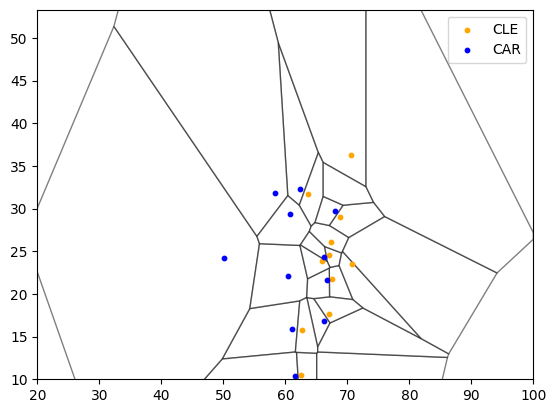

,nflId,playId,frameId,position,voronoiArea
0,52595.0,184.0,161.0,WR,35.222298
1,44898.0,184.0,161.0,RB,216.257978
2,44841.0,184.0,161.0,TE,15.632393
3,42347.0,184.0,161.0,WR,18.276804
4,46104.0,184.0,161.0,RB,9.214509


In [572]:
voronoi_visual(samplePlay)

In [510]:
def voronoi_areas(samplePlay):
    samplePlay = pd.merge(
        samplePlay,
        plays[['gameId','playId','yardlineNumber','absoluteYardlineNumber']],
        how = 'left',
        left_on = ['gameId','playId'],
        right_on = ['gameId','playId']
    )
    samplePlayPoints = samplePlay[['nflId','x','y','club','position', 'yardlineNumber','absoluteYardlineNumber', 'frameId', 'playId']]
    new_rows = []

    # Loop over each row in samplePlayPoints
    for _, row in samplePlayPoints.iterrows():
        if row['position'] in ['WR', 'TE', 'RB']:
            if row['position'] in ['WR', 'TE', 'RB']:
                if row['absoluteYardlineNumber'] == (row['yardlineNumber']+10):
                    xpoint = row['x'] - 5
                else:
                    xpoint = row['x'] + 5
            new_row = {
                'x': xpoint,
                'y': row['y'],
                'position': '',
                'club': None,
                'nflId': 0
            }
            new_rows.append(new_row)

    new_rows_df = pd.DataFrame(new_rows)
    filteredSamplePlayPoints = pd.concat([samplePlayPoints, new_rows_df], ignore_index=True)
    points = filteredSamplePlayPoints[['x', 'y']].values
    x_min, x_max = 0, 100
    y_min, y_max = 0, 53.3
    boundary_points = np.array([
        [x_min, y_min],
        [x_min, y_max],
        [x_max, y_min],
        [x_max, y_max]
    ])
    all_points = np.vstack([points, boundary_points])
    vor = Voronoi(all_points)
    boundary_polygon = Polygon([(x_min, y_min), (x_min, y_max), (x_max, y_max), (x_max, y_min)])

    clipped_polygons = []
    polygon_areas = []
    for region in vor.regions:
        if not -1 in region and len(region) > 0:
            polygon = Polygon([vor.vertices[i] for i in region])
            clipped_polygon = polygon.intersection(boundary_polygon)
            if not clipped_polygon.is_empty:
                clipped_polygons.append(clipped_polygon)
                polygon_areas.append(clipped_polygon.area)
    
    

    player_info = {tuple(row[['x', 'y']].values): {'nflId': row['nflId'], 'position': row['position'], 'frameId': row['frameId'], 'playId': row['playId']} 
               for idx, row in filteredSamplePlayPoints.iterrows()}

    new_rows_list = []
    for poly, area in zip(clipped_polygons, polygon_areas):
        for point_coords, info_dict in player_info.items():
            point = Point(point_coords)
            if poly.contains(point) and info_dict['position'] in ['TE', 'RB', 'WR']:
                # Create a new row
                new_row = {
                    'nflId': info_dict['nflId'],
                    'playId': info_dict['playId'],
                    'frameId': info_dict['frameId'],
                    'position': info_dict['position'],
                    'voronoiArea': area
                }
                new_rows_list.append(new_row)
    info = pd.DataFrame(new_rows_list)
    return info

In [511]:
voronoi_areas(samplePlay)

,nflId,playId,frameId,position,voronoiArea
0,42347.0,184.0,155.0,WR,16.838674
1,44898.0,184.0,155.0,RB,121.034653
2,52595.0,184.0,155.0,WR,20.357434
3,46104.0,184.0,155.0,RB,9.071403
4,44841.0,184.0,155.0,TE,9.187727


In [589]:
def clean_data_voronoi(sampleLoop):
    sampleLoop = sampleLoop[(sampleLoop['displayName']!="football")]
    sampleLoop = sampleLoop[(sampleLoop['frameType'] == "AFTER_SNAP") | (sampleLoop['frameType']=="SNAP")]
    sampleLoop = pd.merge(
        sampleLoop,
        plays[['gameId','playId','timeToThrow','timeToSack','pff_manZone','absoluteYardlineNumber','passResult','yardlineNumber']],
        how = "left",
        left_on = ['gameId','playId'],
        right_on=['gameId','playId']
    )
    sampleLoop = sampleLoop[sampleLoop['passResult'].notna()]
    sampleLoop = sampleLoop[sampleLoop['pff_manZone']=="Man"]
    snap_frames = sampleLoop[sampleLoop['frameType'] == 'SNAP'][['gameId', 'playId', 'frameId']]
    sampleLoop = pd.merge(sampleLoop, snap_frames, on=['gameId', 'playId'], how='left', suffixes=('', '_snapframe'))
    sampleLoop['snapframe'] = sampleLoop['frameId_snapframe']
    after_snap_data = sampleLoop.drop(columns=['frameId_snapframe'])
    timeSinceSnap = (after_snap_data['frameId']-after_snap_data['snapframe'])/10
    after_snap_data = after_snap_data[(timeSinceSnap > 1)&(timeSinceSnap<after_snap_data['timeToThrow'])]
    return after_snap_data

In [573]:
def max_voronoi_per_play(after_snap_data):
    results = []
    for name, group in after_snap_data.groupby(['gameId', 'playId', 'frameId']):
        frame = group[['nflId','club','x','y','position','gameId','playId','frameId','timeToThrow','snapframe','absoluteYardlineNumber','yardlineNumber']]
        frame['timeSinceSnap'] = (frame['frameId'] - frame['snapframe'])/10
        new_rows = []
        for _, row in frame.iterrows():
            if row['position'] in ['WR', 'TE', 'RB']:
                if row['absoluteYardlineNumber'] == (row['yardlineNumber']+10):
                    xpoint = row['x'] - 5
                else:
                    xpoint = row['x'] + 5
                new_row = {
                    'x': xpoint,
                    'y': row['y'],
                    'position': '',
                    'club': None,
                    'nflId': 0,
                    'gameId': row['gameId'],
                    'playId': row['playId'],
                    'frameId': row['frameId']
                }
                new_rows.append(new_row)
        new_rows_df = pd.DataFrame(new_rows)
        newFrames = pd.concat([frame, new_rows_df], ignore_index=True)
        points = newFrames[['x', 'y']].values
        x_min, x_max = 0, 100
        y_min, y_max = 0, 53.3
        boundary_points = np.array([
            [x_min, y_min],
            [x_min, y_max],
            [x_max, y_min],
            [x_max, y_max]
        ])
        all_points = np.vstack([points, boundary_points])
        vor = Voronoi(all_points)
        boundary_polygon = Polygon([(x_min, y_min), (x_min, y_max), (x_max, y_max), (x_max, y_min)])
        
        clipped_polygons = []
        polygon_areas = []
        for region in vor.regions:
            if not -1 in region and len(region) > 0:
                polygon = Polygon([vor.vertices[i] for i in region])
                clipped_polygon = polygon.intersection(boundary_polygon)
                if not clipped_polygon.is_empty:
                    clipped_polygons.append(clipped_polygon)
                    polygon_areas.append(clipped_polygon.area)

        player_info = {tuple(row[['x', 'y']].values): {'nflId': row['nflId'], 'position': row['position'], 'TTT': row['timeToThrow'], 'timeSinceSnap': row['timeSinceSnap'], 'yardline':row['x'],'absoluteYardLine':row['absoluteYardlineNumber'], 'playYardLine':row['yardlineNumber']} 
                    for idx, row in newFrames.iterrows()}
        for poly, area in zip(clipped_polygons, polygon_areas):
            for point_coords, info in player_info.items():
                point = Point(point_coords)
                if poly.contains(point) and info['position'] in ['TE','RB','WR']:
                    if info['absoluteYardLine'] == (info['playYardLine']+10):
                        downfield = info['yardline'] - info['absoluteYardLine']
                    else:
                        downfield = info['absoluteYardLine'] - info['yardline']
                    results.append({
                        'gameId': name[0],
                        'playId': name[1],
                        'frameId': name[2],
                        'nflId': info['nflId'],
                        'position': info['position'],
                        'voronoiArea': area,
                        'timeToThrow': info['TTT'],
                        'timeSinceSnap': info['timeSinceSnap'],
                        'yardsDownField': downfield
                    })
    results = pd.DataFrame(results)
    results['valueOfSeparation'] = (results['voronoiArea'] * (1.01750249 ** results['yardsDownField']))
    return results

In [367]:
def group_voronoi_results(results):
    max_separation_per_play = results.groupby(['gameId', 'playId', 'nflId'])['valueOfSeparation'].max().reset_index()
    max_separation_per_play.columns = ['gameId', 'playId', 'routeRunnerId', 'maxValueOfSeparation']
    
    result = pd.merge(
        max_separation_per_play,
        results[['gameId', 'playId', 'nflId', 'frameId', 'valueOfSeparation', 'timeSinceSnap', 'timeToThrow', 'yardsDownField']],  # Select necessary columns
        how='left',
        left_on=['gameId', 'playId', 'routeRunnerId', 'maxValueOfSeparation'],  # Join on the maximum separation
        right_on=['gameId', 'playId', 'nflId', 'valueOfSeparation']  # Join on the separation value
    )
    result = result.drop(columns=['nflId','valueOfSeparation'])
    return result

In [583]:
sample = weekOneTracking[(weekOneTracking['gameId']==2022091101)]

In [590]:
cleanedSample = clean_data_voronoi(sample)
cleanedSample

,gameId,playId,nflId,displayName,frameId,frameType,time,jerseyNumber,club,playDirection,...,dir,event,position,timeToThrow,timeToSack,pff_manZone,absoluteYardlineNumber,passResult,yardlineNumber,snapframe
242,2022091101,184,41264.0,Joel Bitonio,155,AFTER_SNAP,2022-09-11 17:08:53.2,75.0,CLE,left,...,100.81,NaN,G,2.069,NaN,Man,64,C,46,144
243,2022091101,184,41264.0,Joel Bitonio,155,AFTER_SNAP,2022-09-11 17:08:53.2,75.0,CLE,left,...,100.81,NaN,G,2.069,NaN,Man,64,C,46,144
244,2022091101,184,41264.0,Joel Bitonio,155,AFTER_SNAP,2022-09-11 17:08:53.2,75.0,CLE,left,...,100.81,NaN,G,2.069,NaN,Man,64,C,46,144
245,2022091101,184,41264.0,Joel Bitonio,155,AFTER_SNAP,2022-09-11 17:08:53.2,75.0,CLE,left,...,100.81,NaN,G,2.069,NaN,Man,64,C,46,144
246,2022091101,184,41264.0,Joel Bitonio,155,AFTER_SNAP,2022-09-11 17:08:53.2,75.0,CLE,left,...,100.81,NaN,G,2.069,NaN,Man,64,C,46,144
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
436343,2022091101,3707,53539.0,James Hudson,149,AFTER_SNAP,2022-09-11 19:56:46.9,66.0,CLE,left,...,114.32,pass_forward,T,2.002,NaN,Man,68,C,42,129
436344,2022091101,3707,53539.0,James Hudson,149,AFTER_SNAP,2022-09-11 19:56:46.9,66.0,CLE,left,...,114.32,pass_forward,T,2.002,NaN,Man,68,C,42,129
436345,2022091101,3707,53539.0,James Hudson,149,AFTER_SNAP,2022-09-11 19:56:46.9,66.0,CLE,left,...,114.32,pass_forward,T,2.002,NaN,Man,68,C,42,129
436346,2022091101,3707,53539.0,James Hudson,149,AFTER_SNAP,2022-09-11 19:56:46.9,66.0,CLE,left,...,114.32,pass_forward,T,2.002,NaN,Man,68,C,42,129


In [591]:
voronoiAreas = max_voronoi_per_play(cleanedSample)

C:\Users\bhaga\AppData\Local\Temp\ipykernel_26912\299779120.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frame['timeSinceSnap'] = (frame['frameId'] - frame['snapframe'])/10
C:\Users\bhaga\AppData\Local\Temp\ipykernel_26912\299779120.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frame['timeSinceSnap'] = (frame['frameId'] - frame['snapframe'])/10
C:\Users\bhaga\AppData\Local\Temp\ipykernel_26912\299779120.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataF

In [592]:
groupedVoronoi = group_voronoi_results(voronoiAreas)
groupedVoronoi

,gameId,playId,routeRunnerId,maxValueOfSeparation,frameId,timeSinceSnap,timeToThrow,yardsDownField
0,2022091101,184,42347.0,18.847731,164,2.0,2.069,0.98
1,2022091101,184,44841.0,20.233497,164,2.0,2.069,2.06
2,2022091101,184,44898.0,193.159538,161,1.7,2.069,-6.51
3,2022091101,184,46104.0,20.987404,164,2.0,2.069,-0.66
4,2022091101,184,52595.0,43.997981,164,2.0,2.069,2.05
...,...,...,...,...,...,...,...,...
65,2022091101,3591,53520.0,402.497113,202,2.7,3.137,8.36
66,2022091101,3707,42347.0,53.260090,140,1.1,2.002,0.02
67,2022091101,3707,46104.0,53.300158,149,2.0,2.002,-8.05
68,2022091101,3707,52523.0,70.302585,145,1.6,2.002,0.05
